In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import warnings
warnings.filterwarnings("ignore")

* Please email me (ianzhang@connect.hku.hk) if you find any mistakes in the script. 

* My consultation timeslot: Wednesday, 16:00 - 17:00, RR113. 

# Data Augmentation

Given the model 
$$p(\theta,z|\mathbf{y}_{\mathrm{obs}}),$$
we can obtain the **complete-data posterior distribution**
$$p(\theta|\mathbf{y}_{\mathrm{obs}}, z),$$
and the **conditional predictive distribution**
$$p(z|\mathbf{y}_{\mathrm{obs}}, \theta).$$
Our goal is to draw samples from $p(\theta|\mathbf{y}_{\mathrm{obs}})$, where
$$
p(\theta|\mathbf{y}_{\mathrm{obs}})=\int p(\theta,z|\mathbf{y}_{\mathrm{obs}})dz. 
$$

## The original DA algorithm (multiple imputation)

I-step: Draw samples $\{\theta^{(k,j)}\}_{j=1}^m$ from $p_k(\theta|\mathbf{y}_{\mathrm{obs}})$, and obtain $\{z^{(k,j)}\}_{j=1}^m$, where $z^{(k,j)}\sim p(z|\mathbf{y}_{\mathrm{obs}},\theta^{(k,j)})$. 

P-step: Update the posterior:
$$
p_{k+1}(\theta|\mathbf{y}_{\mathrm{obs}})=\frac{1}{m}\sum_{j=1}^mp(\theta|\mathbf{y}_{\mathrm{obs}},z^{(k,j)}).
$$

## The DA algorithm

Some insights about the original DA algorithm:
* The P-step can be integrated into the I-step. 
* The I-step can be modified in the following way:

(1) Draw samples $\{\theta^{(k,j)}\}_{j=1}^m$ from $p_k(\theta|\mathbf{y}_{\mathrm{obs}})$, where
$$
p_k(\theta|\mathbf{y}_{\mathrm{obs}})=\frac{1}{m}\sum_{j=1}^mp(\theta|\mathbf{y}_{\mathrm{obs}},z^{(k-1,j)}). 
$$
(2) Draw samples $\{z^{(k,j)}\}_{j=1}^m$ from $p_k(z|\mathbf{y}_{\mathrm{obs}})$, where
$$
p_k(z|\mathbf{y}_{\mathrm{obs}})=\frac{1}{m}\sum_{j=1}^mp(z|\mathbf{y}_{\mathrm{obs}},\theta^{(k,j)}). 
$$
But the step (2) is based on **stratification**. 

What if we let the step (1) to be based on stratification too? In that case we would have

(1) Draw samples $\{\theta^{(k,j)}\}_{j=1}^m$, where $\theta^{(k,j)}\sim p(\theta|\mathbf{y}_{\mathrm{obs}},z^{(k-1,j)})$. 

(2) Draw samples $\{z^{(k,j)}\}_{j=1}^m$, where $z^{(k,j)}\sim p(z|\mathbf{y}_{\mathrm{obs}},\theta^{(k,j)})$. 

And we find that this is equivalent to do $m$ **parallel Gibbs**! 

So why not just simplify it to be one single Gibbs:

(1) Draw sample $\theta^{(k)}$, where $\theta^{(k)}\sim p(\theta|\mathbf{y}_{\mathrm{obs}},z^{(k-1)})$. 

(2) Draw sample $z^{(k)}$, where $z^{(k)}\sim p(z|\mathbf{y}_{\mathrm{obs}},\theta^{(k)})$. 

This is the **standard DA algrithm**. We can also draw $z$ first, just choose the convenient one. 

## Example: grouped count data (missing data)

Given the observed data (\# of passages, \# of observations): \{(0,139),(1,128),(2,55),(3,25),(4+,13)\}

Assume the **Poisson model**: 
$$
P(X=x)=\frac{e^{-\lambda}\lambda^x}{x!},\; x=0,1,\dots
$$
for the \# of passages. Try to estimate $\lambda$. 

There are $347=139+128+55+25$ observations $\mathbf{x}_{\mathrm{obs}}$ and 13 missing data $z_{1:13}$. 

If we assume the prior $p(\lambda)\propto 1/\lambda$, the model is
$$
p(\lambda,z_{1:13}|\mathbf{x}_{\mathrm{obs}})\propto\frac{1}{\lambda}e^{-347\lambda}\lambda^{128+55\times2+25\times3}\prod_{j=1}^{13}\frac{e^{-\lambda}\lambda^{z_j}}{z_j!}\mathbf{1}(z_j\ge4). 
$$
so, we can obtain the complete-data posterior distribution
$$\lambda|\mathbf{x}_{\mathrm{obs}}, z_{1:13}\sim Gamma(313+\sum_{j=1}^{13}z_j,360),$$
and the conditional predictive distribution 
$$p(z_j|\mathbf{y}_{\mathrm{obs}}, \lambda)=p(z_j|\lambda)\propto\frac{e^{-\lambda}\lambda^{z_j}}{z_j!}\mathbf{1}(z_j\ge4).$$

Based on the Gibbs, we can obtain the samples $\{\lambda^{(i)},z_{1:13}^{(i)}\}_{i=1}^{n}$. 

* Assume $\lambda^{(0)}=\frac{313+13\times4}{360}$. Compare the two estimators of $\lambda$: (1) $\hat{\lambda}_1=\frac{1}{n}\sum_{i=1}^n\lambda^{(i)}$; (2) $\hat{\lambda}_2=\frac{1}{n}\sum_{i=1}^n\frac{313+\sum_{j=1}^{13}z_j^{(i)}}{360}$. 

## Example: probit model (latent variables)

Other than the logistic model, another classic model in binary classification is called the **probit model**:
$$
P(Y=1|x)=\Phi(x^T\beta),
$$
where $Y$ is a binary label, x is the vector of features, $\beta$ is the model parameter and $\Phi$ is the cdf of the standard normal distribution. 

Given data $\{(y_1,x_1),\dots,(y_m,x_m)\}$, and the non-informative prior $p(\beta)\propto 1$, the model is
$$
p(\beta|y_{1:m},x_{1:m})\propto p(y_{1:m},\beta|x_{1:m})=p(y_{1:m}|\beta,x_{1:m})p(\beta)=\prod_{j=1}^m\Phi(x_j^T\beta)^{y_j}(1-\Phi(x_j^T\beta))^{1-y_j}, 
$$
and we can apply the Random Walk to do inference about $\beta$. 

Another way is to use the data augmentation with the Gibbs sampler. To achieve this, we assume the latent variables $z_j=x_j^T\beta+\varepsilon_j$, $j=1,\dots,m$, where $\varepsilon_j\sim N(0,1)$. And we assume $y_j$ depends on $z_j$ deterministically that $y_j=\mathbf{1}(z_j>0)$. To see why this assumption holds, just notice that
$$
P(Y=1|x)=P(\mathbf{1}(Z>0)=1|x)=P(x^T\beta+\varepsilon>0)=P(-\varepsilon<x^T\beta)=\Phi(x^T\beta). 
$$
So, the augmented model is
\begin{align}
p(\beta,z_{1:m}|y_{1:m},x_{1:m})&\propto p(y_{1:m},z_{1:m},\beta|x_{1:m})=p(y_{1:m}|z_{1:m})p(z_{1:m}|\beta,x_{1:m})p(\beta)\\
&=\prod_{j=1}^m(\mathbf{1}(z_j>0)\mathbf{1}(y_j=1)+\mathbf{1}(z_j\le0)\mathbf{1}(y_j=0))\exp(-\frac{(z_j-x_j^T\beta)^2}{2}).
\end{align}
Easy to derive that
$$
\beta|z_{1:m},y_{1:m},x_{1:m}\sim N((X^TX)^{-1}X^Tz_{1:m},(X^TX)^{-1}), 
$$
where $X=[x_{1:m}]_{m\times p}$, and
$$
p(z_j|\beta,y_{1:m},x_{1:m})\propto(\mathbf{1}(z_j>0)\mathbf{1}(y_j=1)+\mathbf{1}(z_j\le0)\mathbf{1}(y_j=0))\exp(-\frac{(z_j-x_j^T\beta)^2}{2}).
$$

Based on the Gibbs, we can obtain the samples $\{\beta^{(i)},z_{1:m}^{(i)}\}_{i=1}^{n}$. 

* Draw $x_j\sim N(\mathbf{0},I_2)$, $j=1,\dots,20$, and draw $y_{1:20}$ from the probit model with $\beta_0=[-1,2]^T$. Try to draw samples of $\beta$ given $x_{1:20},y_{1:20}$. Compare the trajectories of the Random Walk and the Gibbs. Which one is better? 

# Simulating Annealing

For any distribution $\pi(x)$, its negative log function is called the corresponding **energy function**:
$$
h(x)=-\log(\pi(x)).
$$
In the simulated annealing, based on some intuitions from physics, we redefine the distribution with a new parameter $T$ - **the temperature**: 
$$
\pi_T(x)=\exp(-\frac{h(x)}{T})(=\pi(x)^{1/T}). 
$$

An example:

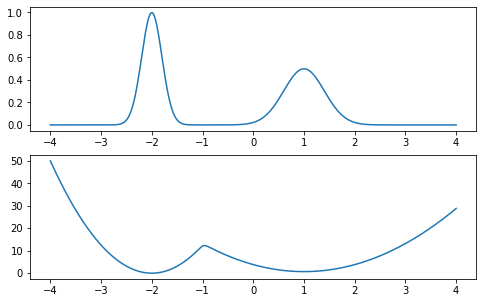

In [2]:
pi = lambda x: 0.5 * st.norm(loc=-2, scale=0.2).pdf(x) + 0.5 * st.norm(loc=1, scale=0.4).pdf(x)
h = lambda x: -np.log(pi(x))

grid_x = np.linspace(-4, 4, 1000)
fig, ax = plt.subplots(2, 1, figsize=[8, 5])
ax[0].plot(grid_x, pi(grid_x))
ax[1].plot(grid_x, h(grid_x))
plt.show()

What if $T$ goes to 0 or infinity?

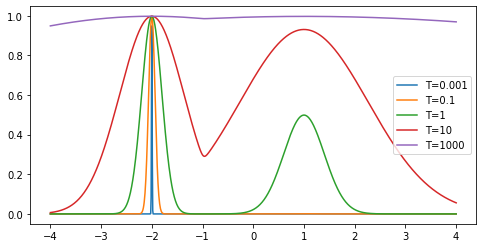

In [3]:
piT = lambda x, T: np.exp(-h(x) / T)
hight = piT(-2, T=1)

grid_x = np.linspace(-4, 4, 1000)
fig, ax = plt.subplots(figsize=[8, 4])
ax.plot(grid_x, piT(grid_x, T=0.001) * hight / piT(-2, T=0.001), label='T=0.001')
ax.plot(grid_x, piT(grid_x, T=0.1) * hight / piT(-2, T=0.1), label='T=0.1')
ax.plot(grid_x, piT(grid_x, T=1), label='T=1')
ax.plot(grid_x, piT(grid_x, T=10) * hight / piT(-2, T=10), label='T=10')
ax.plot(grid_x, piT(grid_x, T=1000) * hight / piT(-2, T=1000), label='T=1000')
ax.legend()
plt.show()

The idea of **Simulating Annealing** is simply to run the **Random Walk** against a redefined target distribution $\pi_T(x)$, and gradually reduce $T$ as the algorithm proceeds. As the temperature decreases, the region around the maximum point would have higher and higher probability to capture the last sample point. 

* Run the Random Walk against the above distribution with Gaussian kernel and step size 2, and set $T=2/n$, where $n$ is iteration number. Begin the walk at the local maximum $x_0=1$ and the total iteration time is $N=200$. What's the probability that the last sample point is trapped by the area around the global maximum point $x=-2$. Run 100 repetitions to estimate this probability and draw all the trajectories of the Random Walk. 

**Think further:** Try different parameter settings to see how different parameters influence the annealing. 

# Root Finding

A common root ﬁnding problem in statistics: assume
$$
l(\theta)=\log(p(y_{\mathrm{obs}}|\theta)), 
$$
and solve $f(\theta)=l'(\theta)=0$ to obtain MLE. 

## Bisection method

The assumptions of the **Bisection method** are
1. $f(\theta)$ is one dimensional;
2. $f(\theta)$ is continuous;
3. We have initial points $a, b$ such that $f(a)f(b)<0$. 

## Convex and concave functions

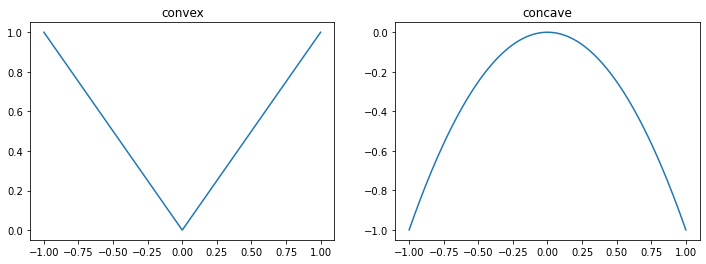

In [4]:
x = np.linspace(-1, 1, 1000)
fv = lambda x: np.abs(x)
fc = lambda x: - x**2

fig, ax = plt.subplots(1, 2, figsize=[12, 4])
ax[0].plot(x, fv(x))
ax[0].set_title('convex')
ax[1].plot(x, fc(x))
ax[1].set_title('concave')
plt.show()

## Newton–Raphson method

Based on the **Taylor expansion**, we have
$$
f(\theta)=f(\theta_0)+f'(\theta_0)(\theta-\theta_0)+\mathcal{o}(\theta-\theta_0). 
$$
If we ignore $\mathcal{o}(\theta-\theta_0)$, $f(\theta_1)=0$ induce
$$
\theta_1=\theta_0-\frac{f(\theta_0)}{f'(\theta_0)}. 
$$
This makes an iteration of the **Newton–Raphson algorithm**. 

### Multiple dimensions

If $\theta$ is $d$-dimensional, $f(\theta)=\nabla l(\theta)$ would be a multivalued function on a $d$-dimensional space, but we still have the Taylor expansion
$$
\nabla l(\theta)=\nabla l(\theta_0)+\nabla^2 l(\theta_0)(\theta-\theta_0)+\mathcal{o}(||\theta-\theta_0||), 
$$
which results in an iteration of the Newton–Raphson algorithm in the $d$-dimensional space
$$
\theta_1=\theta_0+I(\theta_0)^{-1}\nabla l(\theta_0),
$$
where $I(\theta_0)=-\nabla^2 l(\theta_0)$ is called the **observed information matrix**. Different from the Bisection method, the Newton–Raphson algorithm can be easily generalized to high dimension space. 

To speed up the algrithm, a simple idea called the **Fisher scoring algorithm** replaces $I(\theta_0)$ by $J(\theta_0)=\mathbb{E}[I(\theta_0)]$ which is called the **Fisher/expected information matrix**. This replacement is valid because
\begin{align}
\frac{1}{n}I(\theta_0)&=-\frac{1}{n}\nabla^2 l(\theta_0)=-\frac{1}{n}\nabla^2 \log(p(y_{\mathrm{obs}}|\theta_0))=-\frac{1}{n}\nabla^2 \log(\prod_{i=1}^np(y_i|\theta_0))=-\frac{1}{n}\sum_{i=1}^n\nabla^2\log(p(y_i|\theta_0))\\
&\approx-\mathbb{E}[\nabla^2\log(p(y_i|\theta_0))]=\frac{1}{n}\mathbb{E}[I(\theta_0)]=\frac{1}{n}J(\theta_0),
\end{align}
and
$$
I(\theta_0)^{-1}\nabla l(\theta_0)=(\frac{1}{n}I(\theta_0))^{-1}\frac{1}{n}\nabla l(\theta_0)\approx(\frac{1}{n}J(\theta_0))^{-1}\frac{1}{n}\nabla l(\theta_0)=J(\theta_0)^{-1}\nabla l(\theta_0). 
$$